
 Model: LogisticRegression
 Accuracy: 0.5370
 Precision: 0.3453
 Recall: 0.4511
 F1-score: 0.3912
 ROC AUC: 0.5177691609645163
 Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.58      0.63      2681
           1       0.35      0.45      0.39      1319

    accuracy                           0.54      4000
   macro avg       0.51      0.52      0.51      4000
weighted avg       0.57      0.54      0.55      4000



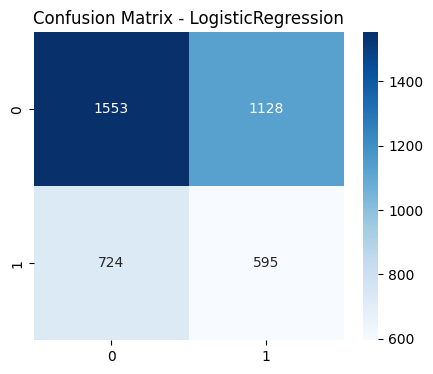


 Model: SVC
 Accuracy: 0.4880
 Precision: 0.3484
 Recall: 0.6353
 F1-score: 0.4501
 ROC AUC: 0.5359893661033658
 Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.42      0.52      2681
           1       0.35      0.64      0.45      1319

    accuracy                           0.49      4000
   macro avg       0.52      0.53      0.49      4000
weighted avg       0.58      0.49      0.50      4000



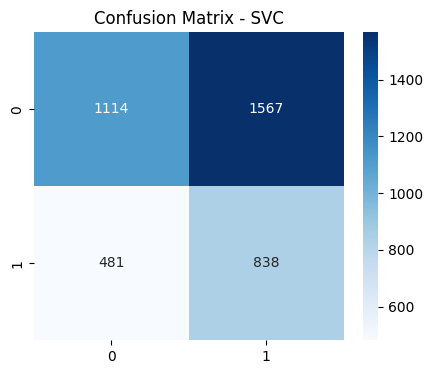


 Model: DecisionTreeClassifier
 Accuracy: 0.5218
 Precision: 0.3366
 Recall: 0.4640
 F1-score: 0.3902
 ROC AUC: 0.5026392446890608
 Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.55      0.61      2681
           1       0.34      0.46      0.39      1319

    accuracy                           0.52      4000
   macro avg       0.51      0.51      0.50      4000
weighted avg       0.56      0.52      0.54      4000



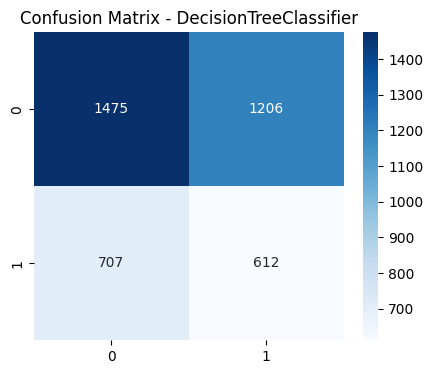


 Model: RandomForestClassifier
 Accuracy: 0.5012
 Precision: 0.3472
 Recall: 0.5823
 F1-score: 0.4350
 ROC AUC: 0.5432294027637838
 Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.46      0.55      2681
           1       0.35      0.58      0.44      1319

    accuracy                           0.50      4000
   macro avg       0.52      0.52      0.49      4000
weighted avg       0.58      0.50      0.51      4000



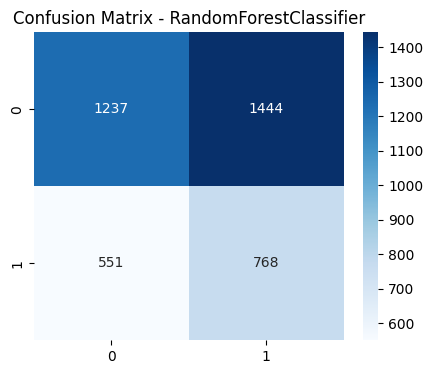


 Model: KNeighborsClassifier
 Accuracy: 0.5235
 Precision: 0.3277
 Recall: 0.4230
 F1-score: 0.3693
 ROC AUC: 0.4900576573020093
 Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.57      0.62      2681
           1       0.33      0.42      0.37      1319

    accuracy                           0.52      4000
   macro avg       0.50      0.50      0.49      4000
weighted avg       0.56      0.52      0.54      4000



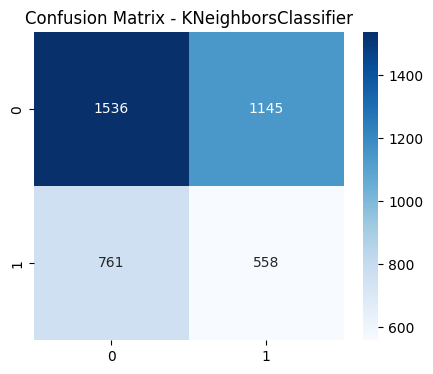

In [4]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from concurrent.futures import ThreadPoolExecutor, as_completed
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE

IMAGE_FOLDER = "/content/drive/MyDrive/images3"

MAX_FILE_SIZE = 1 * 1024 * 1024

def process_image(img_path):
    if os.path.getsize(img_path) > MAX_FILE_SIZE:
        return None

    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if image is None or image.shape[0] < 50 or image.shape[1] < 50:
        return None

    return np.mean(image), np.std(image)

def extract_image_features():
    image_paths, labels = [], []


    for folder in os.listdir(IMAGE_FOLDER):
        folder_path = os.path.join(IMAGE_FOLDER, folder)
        if os.path.isdir(folder_path):
            for img_file in os.listdir(folder_path):
                if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image_paths.append(os.path.join(folder_path, img_file))
                    labels.append(folder)


    features = []
    with ThreadPoolExecutor(max_workers=10) as executor:
        future_to_path = {executor.submit(process_image, path): path for path in image_paths}
        for future in as_completed(future_to_path):
            result = future.result()
            if result is not None:
                features.append(result)

    return pd.DataFrame(features, columns=['mean_intensity', 'std_intensity']), labels


df = pd.read_csv("breast-level_annotations.csv")


df['breast_birads'] = df['breast_birads'].astype(str)
df['target'] = df['breast_birads'].apply(lambda x: 0 if x == 'BI-RADS 1' else 1)


features = ['height', 'width', 'breast_density', 'laterality', 'view_position']
X_csv = df[features].copy()


for col in ['breast_density', 'laterality', 'view_position']:
    X_csv[col] = pd.Categorical(X_csv[col]).codes


X_images, image_labels = extract_image_features()


X = pd.concat([X_csv, X_images], axis=1)
y = df['target']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


X_train.fillna(X_train.mean(), inplace=True)
X_test.fillna(X_test.mean(), inplace=True)


smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

def train_and_evaluate(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob) if y_prob is not None else 'N/A'

    print(f"\n Model: {model.__class__.__name__}")
    print(f" Accuracy: {accuracy:.4f}")
    print(f" Precision: {precision:.4f}")
    print(f" Recall: {recall:.4f}")
    print(f" F1-score: {f1:.4f}")
    print(f" ROC AUC: {roc_auc}")
    print(" Classification Report:\n", classification_report(y_test, y_pred))


    plt.figure(figsize=(5, 4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {model.__class__.__name__}")
    plt.show()


models = [
    LogisticRegression(random_state=42),
    SVC(kernel='rbf', C=1, probability=True),
    DecisionTreeClassifier(random_state=42),
    RandomForestClassifier(n_estimators=100, max_depth=6, random_state=42),
    KNeighborsClassifier(n_neighbors=3)
]


for model in models:
    train_and_evaluate(model, X_train, y_train, X_test, y_test)
